In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
print(torch.__version__)

2.1.0+cu121


In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 700

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['train']),
                            ImageFolder('/content/fer_ckplus', data_transforms['train'])])
val_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['val']),
                            ImageFolder('/content/fer_ckplus', data_transforms['val'])])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.datasets[0].targets + train_data.datasets[1].targets,
    stratify=train_data.datasets[0].targets + train_data.datasets[1].targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
from torchvision.ops.stochastic_depth import StochasticDepth
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.efficientnet import MBConvConfig, FusedMBConvConfig, _MBConvConfig

In [ ]:
#source: https://pytorch.org/vision/stable/_modules/torchvision/models/efficientnet.html
class EfficientNet(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: Sequence[Union[MBConvConfig, FusedMBConvConfig]],
        dropout: float,
        stochastic_depth_prob: float = 0.2,
        num_classes: int = 7,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        last_channel: Optional[int] = None,
    ) -> None:

        super().__init__()
        # _log_api_usage_once(self)

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, _MBConvConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[MBConvConfig]")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                1, firstconv_output_channels, kernel_size=3, stride=2, norm_layer=norm_layer, activation_layer=nn.SiLU
            )
        )

        # building inverted residual blocks
        total_stage_blocks = sum(cnf.num_layers for cnf in inverted_residual_setting)
        stage_block_id = 0
        for cnf in inverted_residual_setting:
            stage: List[nn.Module] = []
            for _ in range(cnf.num_layers):
                # copy to avoid modifications. shallow copy is enough
                block_cnf = copy.copy(cnf)

                # overwrite info if not the first conv in the stage
                if stage:
                    block_cnf.input_channels = block_cnf.out_channels
                    block_cnf.stride = 1

                # adjust stochastic depth probability based on the depth of the stage block
                sd_prob = stochastic_depth_prob * float(stage_block_id) / total_stage_blocks

                stage.append(block_cnf.block(block_cnf, sd_prob, norm_layer))
                stage_block_id += 1

            layers.append(nn.Sequential(*stage))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = last_channel if last_channel is not None else 4 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.SiLU,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(lastconv_output_channels, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init_range = 1.0 / math.sqrt(m.out_features)
                nn.init.uniform_(m.weight, -init_range, init_range)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
inverted_residual_setting = [
            FusedMBConvConfig(1, 3, 1, 12, 12, 2),
            FusedMBConvConfig(4, 3, 2, 12, 24, 4),
            FusedMBConvConfig(4, 3, 2, 24, 48, 4),
            MBConvConfig(4, 3, 2, 48, 64, 6),
            MBConvConfig(6, 3, 1, 64, 128, 9),
            MBConvConfig(6, 3, 2, 128, 128, 12),
        ]
last_channel = 1024
model = EfficientNet(inverted_residual_setting, 0.2, last_channel=last_channel)

In [ ]:
# model = models.efficientnet_v2_s()
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(num_ftrs, 7, bias=True))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 70
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             108
       BatchNorm2d-2           [-1, 12, 32, 32]              24
              SiLU-3           [-1, 12, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           1,728
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              SiLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 12, 32, 32]             192
       BatchNorm2d-8           [-1, 12, 32, 32]              24
   StochasticDepth-9           [-1, 12, 32, 32]               0
      FusedMBConv-10           [-1, 12, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           1,728
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             SiLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 12,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 1.8286, val_loss: 1.8033, val_acc: 0.1409


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 1.7946, val_loss: 1.7830, val_acc: 0.1469


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 1.7879, val_loss: 1.7719, val_acc: 0.1477


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 1.7802, val_loss: 1.7630, val_acc: 0.1482


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 1.7526, val_loss: 1.6820, val_acc: 0.2009


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 1.6498, val_loss: 1.5621, val_acc: 0.2660


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 1.5203, val_loss: 1.4085, val_acc: 0.3226


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 1.4154, val_loss: 1.4005, val_acc: 0.3769


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 1.3212, val_loss: 1.2446, val_acc: 0.4305


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 1.2578, val_loss: 1.1994, val_acc: 0.4309


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 1.2159, val_loss: 1.2746, val_acc: 0.4487
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 1.1671, val_loss: 1.1525, val_acc: 0.4653


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 1.1299, val_loss: 1.1707, val_acc: 0.4330


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 1.1029, val_loss: 1.2679, val_acc: 0.4815
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 1.0682, val_loss: 1.1845, val_acc: 0.4737


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 1.0430, val_loss: 1.2964, val_acc: 0.4766


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 1.0171, val_loss: 1.0350, val_acc: 0.5341


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 0.9962, val_loss: 1.0009, val_acc: 0.5541


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 0.9748, val_loss: 1.0615, val_acc: 0.5461


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 0.9592, val_loss: 1.0390, val_acc: 0.5013


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 0.9403, val_loss: 0.9329, val_acc: 0.6001


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 0.9299, val_loss: 0.9582, val_acc: 0.5691


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 0.9123, val_loss: 1.0054, val_acc: 0.5314


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 0.8972, val_loss: 0.8985, val_acc: 0.5937


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 0.8896, val_loss: 0.8929, val_acc: 0.6160


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 0.8698, val_loss: 0.8744, val_acc: 0.6133


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 0.8631, val_loss: 0.9123, val_acc: 0.5959


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 0.8517, val_loss: 0.8997, val_acc: 0.5563


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 0.8434, val_loss: 0.8327, val_acc: 0.6211


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 0.8350, val_loss: 0.8806, val_acc: 0.6084


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 0.8198, val_loss: 0.9056, val_acc: 0.5900


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 0.8122, val_loss: 0.9058, val_acc: 0.6022


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 0.7966, val_loss: 0.8128, val_acc: 0.6481


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 0.7908, val_loss: 0.8235, val_acc: 0.6379


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 0.7801, val_loss: 0.8190, val_acc: 0.6213


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 0.7663, val_loss: 0.8007, val_acc: 0.6567


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 0.7603, val_loss: 0.8335, val_acc: 0.6310


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 0.7488, val_loss: 0.8095, val_acc: 0.6399


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 0.7401, val_loss: 0.8244, val_acc: 0.6613
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.7281, val_loss: 0.7849, val_acc: 0.6454


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00064, train_loss: 0.7229, val_loss: 0.7992, val_acc: 0.6560


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00061, train_loss: 0.7117, val_loss: 0.7945, val_acc: 0.6508


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00058, train_loss: 0.6991, val_loss: 0.7980, val_acc: 0.6576


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00055, train_loss: 0.6852, val_loss: 0.7743, val_acc: 0.6713


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00052, train_loss: 0.6761, val_loss: 0.7911, val_acc: 0.6358


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00048, train_loss: 0.6631, val_loss: 0.7712, val_acc: 0.6769


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00045, train_loss: 0.6584, val_loss: 0.7938, val_acc: 0.6578


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00042, train_loss: 0.6398, val_loss: 0.7856, val_acc: 0.6547


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00039, train_loss: 0.6322, val_loss: 0.7580, val_acc: 0.6908


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00036, train_loss: 0.6197, val_loss: 0.7604, val_acc: 0.6816


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00033, train_loss: 0.6114, val_loss: 0.7518, val_acc: 0.6834


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00030, train_loss: 0.5964, val_loss: 0.7750, val_acc: 0.6674


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00027, train_loss: 0.5847, val_loss: 0.7431, val_acc: 0.6836


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00024, train_loss: 0.5780, val_loss: 0.7426, val_acc: 0.6708


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00021, train_loss: 0.5645, val_loss: 0.7596, val_acc: 0.6793


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00019, train_loss: 0.5580, val_loss: 0.7492, val_acc: 0.7000


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00016, train_loss: 0.5448, val_loss: 0.7432, val_acc: 0.6803


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00014, train_loss: 0.5358, val_loss: 0.7525, val_acc: 0.6769


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00012, train_loss: 0.5228, val_loss: 0.7635, val_acc: 0.6621


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00010, train_loss: 0.5155, val_loss: 0.7637, val_acc: 0.6905


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00008, train_loss: 0.5053, val_loss: 0.7759, val_acc: 0.6920


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00006, train_loss: 0.4979, val_loss: 0.7360, val_acc: 0.6879


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00005, train_loss: 0.4933, val_loss: 0.7206, val_acc: 0.7082


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00004, train_loss: 0.4926, val_loss: 0.7524, val_acc: 0.7185
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00003, train_loss: 0.4828, val_loss: 0.7632, val_acc: 0.6994


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00002, train_loss: 0.4778, val_loss: 0.7278, val_acc: 0.6972


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00001, train_loss: 0.4759, val_loss: 0.7555, val_acc: 0.7101


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00000, train_loss: 0.4741, val_loss: 0.7807, val_acc: 0.6816


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00000, train_loss: 0.4700, val_loss: 0.7472, val_acc: 0.7030


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00000, train_loss: 0.4716, val_loss: 0.7527, val_acc: 0.6907
Training complete in 106m 11s
Best val Acc: 0.718503


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5612 , roc: 0.9133 , f1: 0.5264 , recall: 0.6726


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.7292 , roc: 0.962 , f1: 0.7299 , recall: 0.7312


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/efficientnetraf.pt')

In [ ]:
results = {'acc': [0.14087301587301587, 0.1468906469052139, 0.1476580831031513, 0.1482184605108193, 0.20086339611069265, 0.26601182741247664, 0.3225900638475891, 0.37689470120050333, 0.43045869574443507, 0.43089908807694866, 0.4487313975091695, 0.4653101744706816, 0.4330327367489807, 0.481476538450292, 0.47371393121065586, 0.4766205933042049, 0.534097366062633, 0.5541321203058925, 0.5460552819038619, 0.5013120187846088, 0.6000752935512665, 0.5691355436717693, 0.5314443649452703, 0.5936536682870426, 0.6160486759758258, 0.6133171769337855, 0.5959119354287338, 0.5562524891733057, 0.621098878833929, 0.608383276252065, 0.5899864970331826, 0.6022443795544759, 0.6481099590616395, 0.6378837183948924, 0.6212910577322569, 0.6566610490500613, 0.6309610315500944, 0.6399068980155302, 0.6612569004307366, 0.6453657798345498, 0.6560458928280156, 0.6507874021806312, 0.6575630343807626, 0.6713327370767972, 0.635803297227074, 0.6768913688987218, 0.6578344224926551, 0.6546629139651909, 0.6908135045911143, 0.6815976548808067, 0.6833893347815717, 0.6674315707181531, 0.683557735373695, 0.6708193496714202, 0.6793242381322707, 0.6999580466636213, 0.6803337480624597, 0.6768815331880385, 0.6621375398139813, 0.6904556887376102, 0.6920317620866671, 0.6878679337581375, 0.7082394706038688, 0.7185034485765652, 0.6994381815332853, 0.6972025485563018, 0.7101294774049187, 0.6815563243800489, 0.7029917233600514, 0.6906974528890117], 'f1': [0.0670232850849591, 0.07827526968068226, 0.08073110063984278, 0.08024332630763317, 0.16557315450501758, 0.2273664282284972, 0.2936126499241974, 0.35697292192456614, 0.44045838138762367, 0.4214694934156327, 0.4287001605060042, 0.46956267189484757, 0.43024714482200554, 0.4878861909827298, 0.4784250459538586, 0.49693676656105873, 0.5303956590183898, 0.568961092743257, 0.5536257063136583, 0.4973421365144719, 0.6075407380701862, 0.5761462513173098, 0.5532383851898866, 0.6164342448768018, 0.6264133138371493, 0.6342772316514652, 0.6129135389777407, 0.5710378527160476, 0.6322412809320149, 0.6163171298315768, 0.5948097369226184, 0.6046450037937746, 0.6457916467005556, 0.6508012824504309, 0.6315722982249473, 0.6683256542120793, 0.645132198632922, 0.6602192467687658, 0.668365563555631, 0.659597442823317, 0.6575352659665928, 0.6538621266747688, 0.6631926314312848, 0.6747955757133369, 0.6494445523607417, 0.6822955126659744, 0.6652309187093756, 0.6607674743993782, 0.6959973892755176, 0.6850935350837333, 0.6799202502181455, 0.6784124149065348, 0.68466927523464, 0.6761143229698299, 0.6751391218279116, 0.703951001548339, 0.6911938236927284, 0.6942845981397053, 0.6682445067477324, 0.6861160004992719, 0.6967548565411498, 0.6878672681707109, 0.7057184380326676, 0.707581402170156, 0.7024933306565293, 0.6967504944737394, 0.7054912820174575, 0.6823208353484917, 0.7026003418279972, 0.7005036313125947], 'rec': [0.0439719240297275, 0.23510601320820299, 0.11577075925538591, 0.09247675401521557, 0.20738620914677255, 0.24349581469562273, 0.28386212211834133, 0.38583107561971836, 0.5097689538778574, 0.47627873843995544, 0.4678631440975088, 0.48596849909625434, 0.5977640274253208, 0.5393246095617333, 0.5298423068159911, 0.6092623059614113, 0.5659266824639514, 0.6360718597763587, 0.6279886582353446, 0.5506253813020731, 0.6334458994660721, 0.6031458618132811, 0.6228958811787827, 0.6889294615710081, 0.6416351397569883, 0.6845664104159865, 0.6529405638573081, 0.612555722713268, 0.6593746629370604, 0.6807327107071498, 0.6400198603242176, 0.612824213805981, 0.6671194758866982, 0.675812795645739, 0.6572298665646797, 0.6915084048830012, 0.6917078689618569, 0.705793904426443, 0.6826145312704537, 0.6986213123242129, 0.6722319815483336, 0.6693365884389922, 0.6717225780811062, 0.6921021096862182, 0.6741881732401399, 0.6892951195938659, 0.6800743764347786, 0.6722598155784517, 0.7055051486861786, 0.6958600125738889, 0.6866933913030014, 0.6987766571776838, 0.6948903406640234, 0.6896233936099642, 0.674390857700968, 0.7177455388684324, 0.7143294300080159, 0.7288191371100329, 0.6771071845458162, 0.6836226147321172, 0.7071496965376991, 0.6915955513743964, 0.7079730304820341, 0.7037873045601044, 0.7071190834778106, 0.6989538050900013, 0.7042443645930616, 0.6844332161405668, 0.7040015397845163, 0.7157798420644046], 'prec': [0.14087301587301587, 0.1468906469052139, 0.1476580831031513, 0.1482184605108193, 0.20086339611069265, 0.26601182741247664, 0.3225900638475891, 0.37689470120050333, 0.43045869574443507, 0.43089908807694866, 0.4487313975091695, 0.4653101744706816, 0.4330327367489807, 0.481476538450292, 0.47371393121065586, 0.4766205933042049, 0.534097366062633, 0.5541321203058925, 0.5460552819038619, 0.5013120187846088, 0.6000752935512665, 0.5691355436717693, 0.5314443649452703, 0.5936536682870426, 0.6160486759758258, 0.6133171769337855, 0.5959119354287338, 0.5562524891733057, 0.621098878833929, 0.608383276252065, 0.5899864970331826, 0.6022443795544759, 0.6481099590616395, 0.6378837183948924, 0.6212910577322569, 0.6566610490500613, 0.6309610315500944, 0.6399068980155302, 0.6612569004307366, 0.6453657798345498, 0.6560458928280156, 0.6507874021806312, 0.6575630343807626, 0.6713327370767972, 0.635803297227074, 0.6768913688987218, 0.6578344224926551, 0.6546629139651909, 0.6908135045911143, 0.6815976548808067, 0.6833893347815717, 0.6674315707181531, 0.683557735373695, 0.6708193496714202, 0.6793242381322707, 0.6999580466636213, 0.6803337480624597, 0.6768815331880385, 0.6621375398139813, 0.6904556887376102, 0.6920317620866671, 0.6878679337581375, 0.7082394706038688, 0.7185034485765652, 0.6994381815332853, 0.6972025485563018, 0.7101294774049187, 0.6815563243800489, 0.7029917233600514, 0.6906974528890117], 'roc': [0.5368766931179144, 0.5639684178269168, 0.5739923396922607, 0.5953540202442681, 0.6502745472754758, 0.7186607094867151, 0.7780312848786789, 0.7919091910158468, 0.8367783231012409, 0.8524724819547048, 0.8348263688361189, 0.862683913278277, 0.8553765657575397, 0.8580795079238775, 0.8655378189821193, 0.8767316358959153, 0.890520979697678, 0.8990250017879368, 0.887892778007952, 0.8847954826837838, 0.911139402632367, 0.9066380685872973, 0.9000380271056424, 0.9153315057231778, 0.9181501578035917, 0.919000029809594, 0.915549926607023, 0.9187495930876965, 0.9281411977192298, 0.9237094154660725, 0.9188033968736934, 0.9161022592631438, 0.9326070602243268, 0.9304996930966202, 0.930195798612534, 0.9312972230004188, 0.9305486476292607, 0.9329449817484836, 0.9293313436548927, 0.9380653370833206, 0.9330979686745728, 0.9352591290535063, 0.9344663178500185, 0.9397482667485173, 0.9364851165210553, 0.9397783873109686, 0.9376602681951101, 0.9404673154766948, 0.944164479764036, 0.939208121475947, 0.944112647395692, 0.9424245078768505, 0.9470864065487119, 0.945620596275967, 0.943491369815484, 0.9449372621055049, 0.9478930227614976, 0.9476054230246048, 0.9462205075884385, 0.946289925227911, 0.9462837833794217, 0.950863151811114, 0.9533250808674628, 0.9509118497391934, 0.9461983640990207, 0.9523895637136665, 0.9488829028732054, 0.9463566644412007, 0.9507100274046519, 0.9477561888062834], 'val_loss': [1.8033245570319039, 1.783009123120989, 1.7718805864879064, 1.7630272020612445, 1.6819714525767735, 1.5620816782542637, 1.4085437835965837, 1.4005030734198434, 1.244643601008824, 1.1993729387010847, 1.274600031716483, 1.152516369819641, 1.1706741598674228, 1.2678657715661186, 1.1845236458097186, 1.2963953481401715, 1.0350171606881278, 1.0008711842128208, 1.0615467064721245, 1.0389856004714966, 0.9328647358076912, 0.9581892916134426, 1.005373706817627, 0.8984825154713222, 0.8929255778448922, 0.8743552960668292, 0.9123499700001307, 0.8997151579175676, 0.8326926735469273, 0.880597392150334, 0.905608092376164, 0.9057561758586339, 0.8127658724784851, 0.8235275799887521, 0.8190231684276036, 0.8006961165155684, 0.8334647372790746, 0.8094586603982108, 0.8244026807376317, 0.7849054077693395, 0.7991590026446751, 0.7945402026176452, 0.7979924545969281, 0.7743371915817261, 0.7910591418402536, 0.771237998008728, 0.7938228164400373, 0.7855968182427543, 0.7579748865536281, 0.7604086232185364, 0.7517776145253863, 0.7749628182819911, 0.7431343953950065, 0.7426454646246774, 0.7596261361667088, 0.7491930328096662, 0.7432385127885001, 0.7524980633599417, 0.763547842502594, 0.7636969028200422, 0.7758674045971462, 0.7359874132701328, 0.7205569444383894, 0.7523805298124041, 0.7632189737047468, 0.7278435264314924, 0.7555005742822375, 0.7807376684461321, 0.747228194986071, 0.7527346764292036], 'train_loss': [1.8286100128254599, 1.7946188484556993, 1.7879371671776783, 1.780225095396757, 1.7526375563582006, 1.649828607629742, 1.520332189398723, 1.415414994841446, 1.3211668358615456, 1.2578102284731787, 1.2159099056083662, 1.1671252606707259, 1.1299149213921955, 1.1028995204551513, 1.0681633801387334, 1.043040883558796, 1.0171096163489424, 0.9961515624941436, 0.9747585560085975, 0.9592023499737781, 0.9403253661866412, 0.9298721595600226, 0.912312947605696, 0.8972290052859808, 0.8895571077840131, 0.8698006946138971, 0.8630635548231197, 0.8517094270209582, 0.8434291101695331, 0.8350297903785993, 0.8197722583679206, 0.8122122228438146, 0.7965727259437593, 0.7908039484948223, 0.7801443101309053, 0.7663079073828876, 0.7603399319771749, 0.7488369625842867, 0.740078039290276, 0.7281460549077301, 0.722861435983214, 0.7117345392207362, 0.6991173481712629, 0.6851980596872623, 0.676052268441852, 0.6631413092747656, 0.6583600627152755, 0.6397584950157856, 0.63224888580083, 0.619715297155464, 0.6113901790684318, 0.5963785012186614, 0.5847147813358748, 0.5780405621879137, 0.564468759776604, 0.5579534968302792, 0.544839453298525, 0.535800020349936, 0.5228099495332381, 0.5155383708025002, 0.5053436927348562, 0.4978801452825091, 0.4932557269299824, 0.4926264784785387, 0.4828202026087105, 0.4778074727130799, 0.47588802321413554, 0.4741145936801354, 0.4699642368633036, 0.47155940548740366], 'lr': [4.5361947486692675e-05, 6.132799627656235e-05, 8.754144172302037e-05, 0.0001234166375013616, 0.0001681520797955934, 0.00022074831405415063, 0.000280030264251649, 0.00034467348578863977, 0.00041323375550157324, 0.0004841793376993065, 0.000555925205356185, 0.0006268684519106947, 0.0006954241025188323, 0.0007600605246869442, 0.0008193336471592257, 0.0008719192225603906, 0.0009166424129993617, 0.000952504037648759, 0.0009787028958912597, 0.0009946536673014154, 0.0009999999978098962, 0.0009989696999116644, 0.0009958890367062594, 0.000990770667299593, 0.0009836356241694432, 0.0009745132267384943, 0.0009634409608945379, 0.0009504643249529205, 0.0009356366426942059, 0.0009190188442453229, 0.0009006792157046046, 0.000880693118539563, 0.0008591426799104535, 0.0008361164551921577, 0.0008117090640811526, 0.0007860208017828827, 0.0007591572268772463, 0.0007312287275557493, 0.0007023500680127483, 0.0006726399168547585, 0.0006422203594656955, 0.0006112163963318454, 0.0005797554293880546, 0.0005479667384958514, 0.0005159809502047645, 0.00048392950097981224, 0.000451944097100874, 0.0004201561734533363, 0.00038869635343395485, 0.00035769391219129957, 0.0003272762454064393, 0.00029756834579676216, 0.00026869228949408903, 0.00024076673440766172, 0.00021390643263334336, 0.0001882217589126416, 0.00016381825707921974, 0.00014079620635664585, 0.00011925020928955364, 9.92688030014937e-05, 8.093409537690189e-05, 6.432142766219004e-05, 4.9499064872403824e-05, 3.652791527563348e-05, 2.5461280107875014e-05, 1.6344634546818422e-05, 9.21544084458853e-06, 4.1029943873149815e-06, 1.0283033141070992e-06, 4.002190103886344e-09]}


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

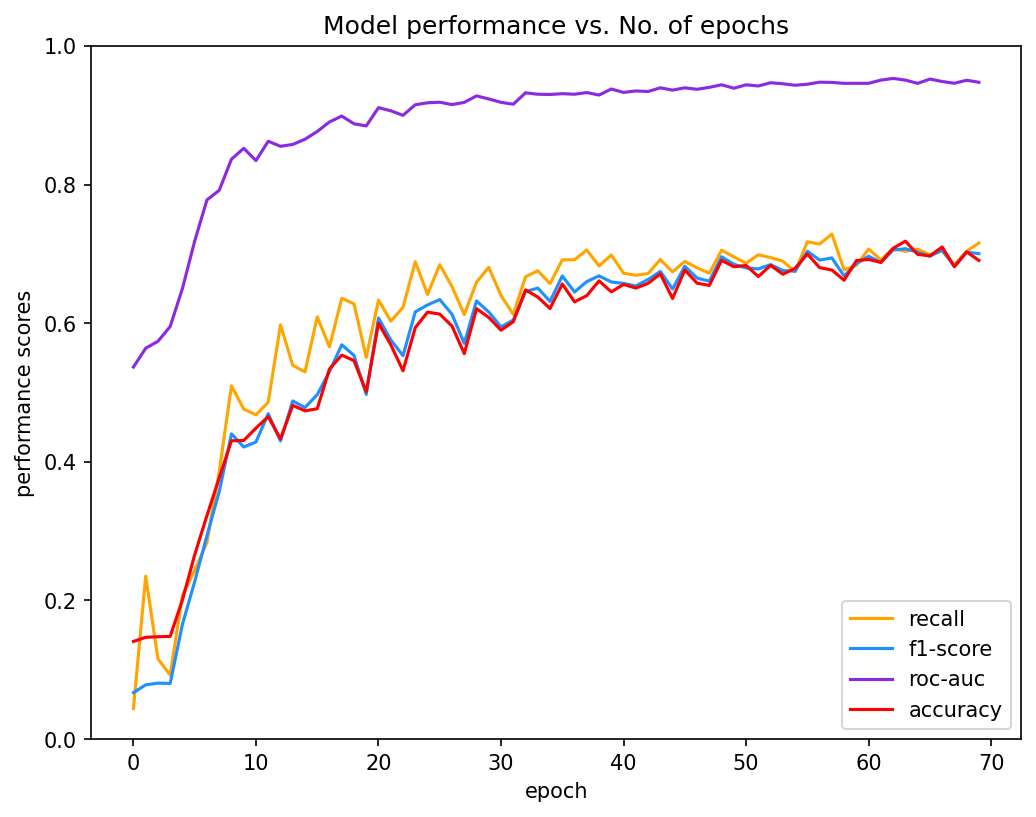

In [ ]:
plot_scores(results)

In [ ]:
def plot_lrs(lrs):
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Epoch')

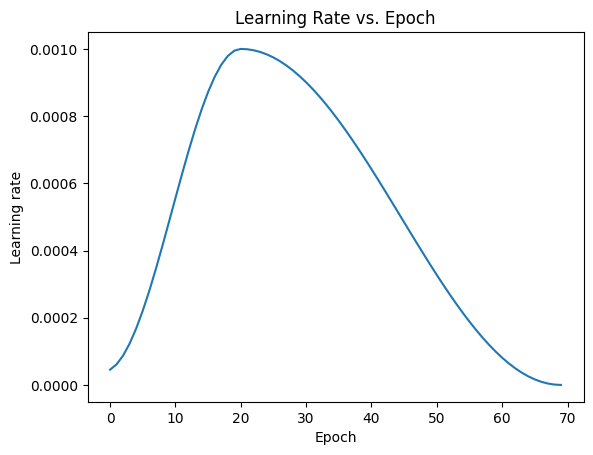

In [ ]:
plot_lrs(res['lr'])

In [ ]:
criterion = nn.CrossEntropyLoss()
model = EfficientNet(inverted_residual_setting, 0.2, last_channel=last_channel)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/efficientnetraf.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7612 , roc: 0.9615 , f1: 0.7517 , recall: 0.7932


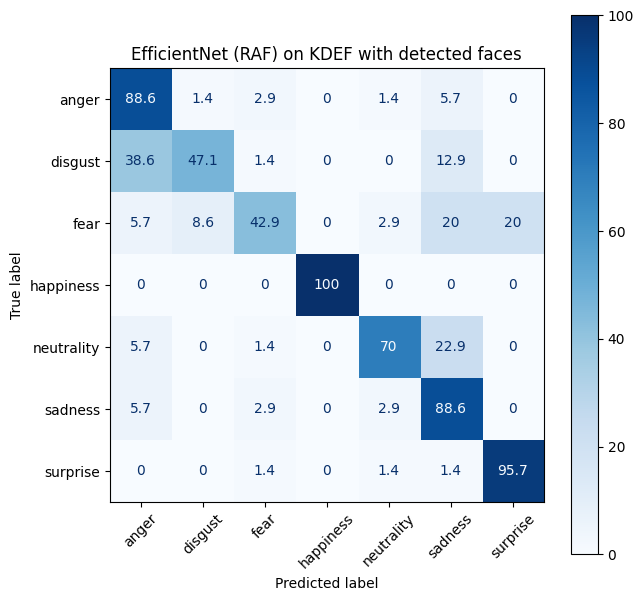

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay

confm1 = sklearn.metrics.confusion_matrix(label_list, pred_list, normalize='true')
confm1 = np.round(confm1*100, 1)
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm1,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("EfficientNet (RAF) on KDEF with detected faces")
plt.show()

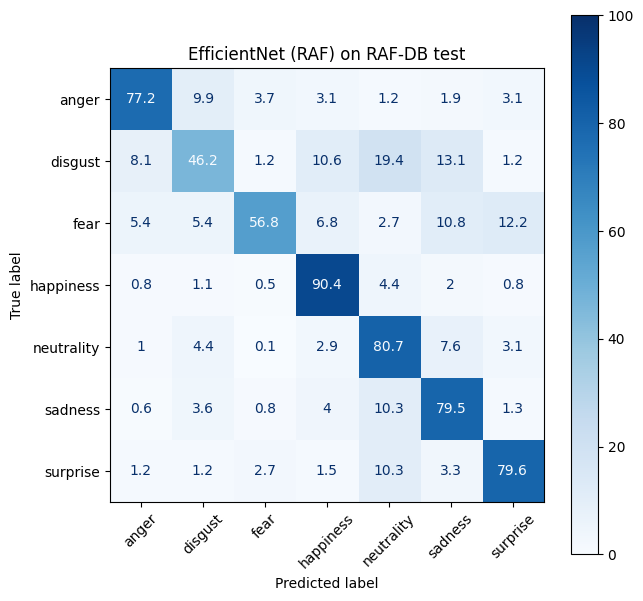

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay

confm1 = sklearn.metrics.confusion_matrix(label_list, pred_list, normalize='true')
confm1 = np.round(confm1*100, 1)
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm1,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("EfficientNet (RAF) on RAF-DB test")
plt.show()

In [ ]:
#source for timing the model execution: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
dummy_input = torch.randn(1,1,64,64, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print("Avg prediction time:", round(mean_syn,3), "Sd:", round(std_syn,3))

Avg prediction time: 23.951 Sd: 4.045
